In [1]:
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(cowplot))
suppressMessages(library(caret))
suppressMessages(library(patchwork))
suppressMessages(library(PRROC))
suppressMessages(library(MetBrewer))

In [2]:
SPATIAL_PATTERNS = c("human_DLPFC_151508",
                     "human_DLPFC_151674",
                     "mouse_cerebellum",
                     "mouse_coronal_slices",
                     "breast_tumor")

Here, we compare the performance of each method using the simulated SVGs. The idea is to compare their accuracy, sensitivity, and specificity.

In [3]:
get_aupr <- function(method){
    df_aupr <- lapply(SPATIAL_PATTERNS, function(tissue){

        aupr <- lapply(c(0.5, 1, 1.5, 2), function(i){
            df <- read.csv(glue::glue("../benchmarking/log_fold_change/{method}/{tissue}_logfc_{i}.csv"), row.names=1)
            if(method == "Sepal"){
                pr <- pr.curve(scores.class0=df$sepal_score, weights.class0=df$spatially_variable, curve=TRUE)
            } else{
                colnames(df) <- c("adjusted_pvalue", "spatially_variable")
                pr <- pr.curve(scores.class0=-df$adjusted_pvalue, weights.class0=df$spatially_variable, curve=TRUE)
            }
            aupr <- pr$auc.integral
            return(aupr)

        })%>% unlist() %>% as.data.frame()

        colnames(aupr) <- "aupr"
        aupr$tissue <- tissue
        aupr$method <- method
        aupr$logfc <- c(0.5, 1, 1.5, 2)

        return(aupr)

    }) %>% Reduce(rbind, .)


    return(df_aupr)
    
}

In [4]:
get_confusion_matrix <- function(method, tissue, logfc){
    df <- read.csv(glue::glue("../benchmarking/log_fold_change/{method}/{tissue}_logfc_{logfc}.csv"), row.names=1)
    
    if(method == "Sepal"){
        # for Sepal method, we select the top 100 genes as SVGs based on sepal score
        df$pred <- ifelse(rank(-df$sepal_score) <= 100, 1, 0)
    
    }else{
        colnames(df) <- c("adjusted_pvalue", "spatially_variable")
        df$pred = ifelse(df$adjusted_pvalue < 0.05, 1, 0) 
    
    }
    
    df$pred <- as.factor(df$pred)
    df$spatially_variable <- as.factor(df$spatially_variable)
    
    cm <- confusionMatrix(data=df$pred, reference=df$spatially_variable, mode="everything", positive = "1")
    
    return(cm)
}

In [5]:
get_accuracy <- function(method){
    df_acc <- lapply(SPATIAL_PATTERNS, function(tissue){
        acc <- lapply(c(0.5, 1, 1.5, 2), function(logfc){
            
            cm <- get_confusion_matrix(method = method, tissue=tissue, logfc = logfc)
            # Access the overall accuracy
            accuracy <- cm$overall[1]
            return(accuracy)
        
        }) %>% unlist() %>%as.data.frame()
        
        colnames(acc) <- "accuracy"
        acc$tissue <- tissue
        acc$method <- method
        acc$logfc <- c(0.5, 1, 1.5, 2)

        return(acc)
    
    
    })%>% Reduce(rbind, .)                     
    
    return(df_acc)
}

In [6]:
get_sensitivity <- function(method){
    df_sen <- lapply(SPATIAL_PATTERNS, function(tissue){
        sensitivity <- lapply(c(0.5, 1, 1.5, 2), function(logfc){
            
            cm <- get_confusion_matrix(method = method, tissue=tissue, logfc = logfc)
            return(cm$byClass[c("Sensitivity")])
        
        }) %>% unlist() %>%as.data.frame()
        
        colnames(sensitivity) <- "sensitivity"
        sensitivity$tissue <- tissue
        sensitivity$method <- method
        sensitivity$logfc <- c(0.5, 1, 1.5, 2)

        return(sensitivity)
    
    
    })%>% Reduce(rbind, .)                     
    
    return(df_sen)
}

get_specificity <- function(method){
    df_spe <- lapply(SPATIAL_PATTERNS, function(tissue){
        specificity <- lapply(c(0.5, 1, 1.5, 2), function(logfc){
            
            cm <- get_confusion_matrix(method = method, tissue=tissue, logfc = logfc)
            return(cm$byClass[c("Specificity")])
        
        }) %>% unlist() %>%as.data.frame()
        
        colnames(specificity) <- "specificity"
        specificity$tissue <- tissue
        specificity$method <- method
        specificity$logfc <- c(0.5, 1, 1.5, 2)

        return(specificity)
    
    
    })%>% Reduce(rbind, .)                     
    
    return(df_spe)
}

In [15]:
method_list = c("MoranI", "scGCO", "SpatialDE", "SOMDE", "SPARK", "SPARK-X", "Spanve", "SpaGCN", "Sepal", "nnSVG", "BOOST-GP")
method_list = c("MoranI", "SOMDE")

df_aupr <- lapply(method_list, 
                 function(method){return(get_aupr(method))}) %>% 
    Reduce(rbind, .)

df_acc <- lapply(method_list, 
                 function(method){return(get_accuracy(method))}) %>% 
    Reduce(rbind, .)

df_sen <- lapply(method_list, 
                 function(method){return(get_sensitivity(method))}) %>% 
    Reduce(rbind, .)

df_spe <- lapply(method_list, 
                 function(method){return(get_specificity(method))}) %>% 
    Reduce(rbind, .)

df_aupr$logfc <- as.factor(df_aupr$logfc)
df_acc$logfc <- as.factor(df_acc$logfc)
df_sen$logfc <- as.factor(df_sen$logfc)
df_spe$logfc <- as.factor(df_spe$logfc)

Warning message in confusionMatrix.default(data = df$pred, reference = df$spatially_variable, :
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in confusionMatrix.default(data = df$pred, reference = df$spatially_variable, :
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in confusionMatrix.default(data = df$pred, reference = df$spatially_variable, :
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in confusionMatrix.default(data = df$pred, reference = df$spatially_variable, :
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in confusionMatrix.default(data = df$pred, reference = df$spatially_variable, :
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message in confusionMatrix.default(data = df$pred, reference = df$spatially_variab

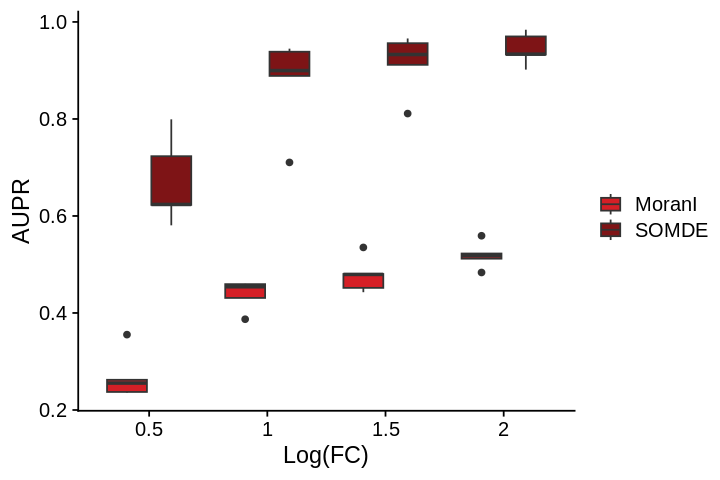

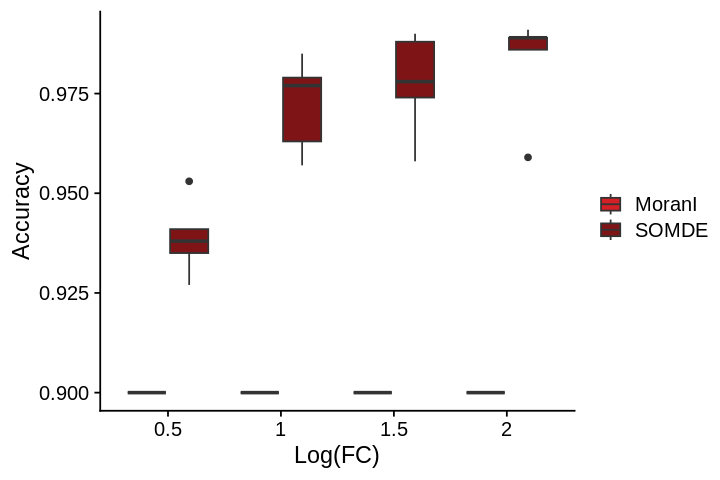

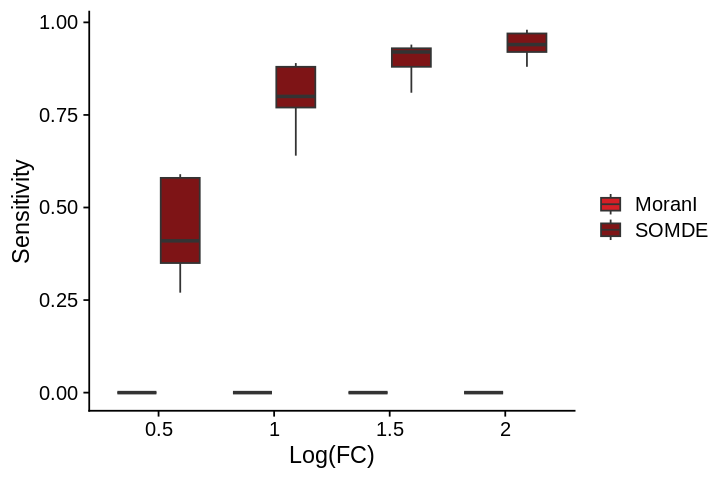

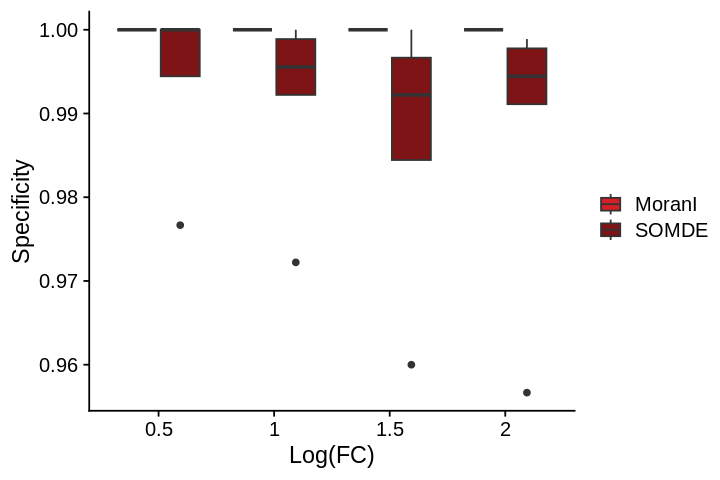

In [17]:
cols <- c("MoranI" = "#D51F26",
         "SOMDE" = "#7E1416",
         "SPARK" = "#208A42",
         "SpatialDE" = "#89288F",
         "scGCO" = "#F47D2B",
         "SPARK-X" = "#FEE500",
         "Spanve" = "#8A9FD1",
         "SpaGCN" = "#C06CAB",
         "Sepal" = "#E6C2DC",
         "BOOST-GP" = "#90D5E4",
         "nnSVG" = "#89C75F")


options(repr.plot.height = 4, repr.plot.width = 6)

p1 <- ggplot(data=df_aupr, aes(x = logfc, y = aupr, fill=method)) +
    geom_boxplot() + 
    scale_fill_manual(values = cols) +
    theme_cowplot() +
    xlab("Log(FC)") + ylab("AUPR") +
    theme(legend.title = element_blank())

p2 <- ggplot(data=df_acc, aes(x = logfc, y = accuracy, fill=method)) +
    geom_boxplot() + 
    scale_fill_manual(values = cols) +
    theme_cowplot() +
    xlab("Log(FC)") + ylab("Accuracy") +
    theme(legend.title = element_blank())

p3 <- ggplot(data=df_sen, aes(x = logfc, y = sensitivity, fill=method)) +
    geom_boxplot() + 
    scale_fill_manual(values = cols) +
    theme_cowplot() +
    xlab("Log(FC)") + ylab("Sensitivity") +
    theme(legend.title = element_blank())

p4 <- ggplot(data=df_spe, aes(x = logfc, y = specificity, fill=method)) +
    geom_boxplot() + 
    scale_fill_manual(values = cols) +
    theme_cowplot() +
    xlab("Log(FC)") + ylab("Specificity") +
    theme(legend.title = element_blank())

p1
p2
p3
p4

In [9]:
# cols=ArchR:::ArchRPalettes$stallion
# cols

In [10]:
# options(repr.plot.height = 5, repr.plot.width = 20)

# cols <- c("MoranI" = "#D51F26",
#          "SOMDE" = "#7E1416",
#          "SPARK" = "#208A42",
#          "SpatialDE" = "#89288F",
#          "scGCO" = "#F47D2B",
#          "SPARK-X" = "#FEE500",
#          "Spanve" = "#8A9FD1",
#          "SpaGCN" = "#C06CAB",
#          "Sepal" = "#E6C2DC",
#          "BOOST-GP" = "#90D5E4",
#          "nnSVG" = "#89C75F")

# p1 <- ggplot(data=df_aupr_mean, aes(x = reorder(method, -mean), y = mean)) +
#     geom_bar(aes(fill = method), stat = "identity", color="black") +
#     geom_jitter(data=df_aupr, aes(x = method, y = aupr), size=0.5) +
#     geom_errorbar(aes(x=method, ymin=mean-sd, ymax=mean+sd), width=0.3, linewidth=0.5) +
#     scale_fill_manual(values = cols) +
#     xlab("") + ylab("") + ggtitle("AUPR") +
#     theme_cowplot() +
#     theme(legend.position = "none",
#          axis.ticks.x = element_blank(),
#          axis.text.x = element_text(angle=60, hjust=1))

# p2 <- ggplot(data=df_acc_mean, aes(x = reorder(method, -mean), y = mean)) +
#     geom_bar(aes(fill = method), stat = "identity", color="black") +
#     geom_jitter(data=df_acc, aes(x = method, y = accuracy), size=0.5) +
#     geom_errorbar(aes(x=method, ymin=mean-sd, ymax=mean+sd), width=0.3, linewidth=0.5) +
#     scale_fill_manual(values = cols) +
#     xlab("") + ylab("") + ggtitle("Accuracy") +
#     theme_cowplot() +
#     theme(legend.position = "none",
#          axis.ticks.x = element_blank(),
#          axis.text.x = element_text(angle=60, hjust=1))

# p3 <- ggplot(data=df_sen_mean, aes(x = reorder(method, -mean), y = mean)) +
#     geom_bar(aes(fill = method), stat = "identity", color="black") +
#     geom_jitter(data=df_sen, aes(x = method, y = sensitivity), size=0.5) +
#     geom_errorbar(aes(x=method, ymin=mean-sd, ymax=mean+sd), width=0.3, linewidth=0.5) +
#     scale_fill_manual(values = cols) +
#     xlab("") + ylab("") + ggtitle("Sensitivity") +
#     theme_cowplot() +
#     theme(legend.position = "none",
#          axis.ticks.x = element_blank(),
#          axis.text.x = element_text(angle=60, hjust=1))

# p4 <- ggplot(data=df_spe_mean, aes(x = reorder(method, -mean), y = mean)) +
#     geom_bar(aes(fill = method), stat = "identity", color="black") +
#     geom_jitter(data=df_spe, aes(x = method, y = specificity), size=0.5) +
#     geom_errorbar(aes(x=method, ymin=mean-sd, ymax=mean+sd), width=0.3, linewidth=0.5) +
#     scale_fill_manual(values = cols) +
#     xlab("") + ylab("") + ggtitle("Specificity") +
#     theme_cowplot() +
#     theme(legend.position = "none",
#          axis.ticks.x = element_blank(),
#          axis.text.x = element_text(angle=60, hjust=1))

# p <- patchwork::wrap_plots(p1, p2, p3, p4, nrow=1)
# print(p)

In [11]:
# ggsave("aupr.pdf", plot=p1, height = 4, width = 5)
# ggsave("accuracy.pdf", plot=p2, height = 4, width = 5)
# ggsave("sensitivity.pdf", plot=p3, height = 4, width = 5)
# ggsave("specificity.pdf", plot=p4, height = 4, width = 5)